In [1]:
using PyPlot
using LightGraphs
using GraphPlot
using LinearAlgebra
using SparseArrays

In [2]:
function test_matrix_1(n)
    A = 2.0*sparse(I,n,n)
    for i=2:n
        A[i,1] = 1.0
        A[1,i] = 1.0
    end
    A
end

test_matrix_1 (generic function with 1 method)

In [3]:
A = test_matrix_1(5);
Array(A)

5×5 Array{Float64,2}:
 2.0  1.0  1.0  1.0  1.0
 1.0  2.0  0.0  0.0  0.0
 1.0  0.0  2.0  0.0  0.0
 1.0  0.0  0.0  2.0  0.0
 1.0  0.0  0.0  0.0  2.0

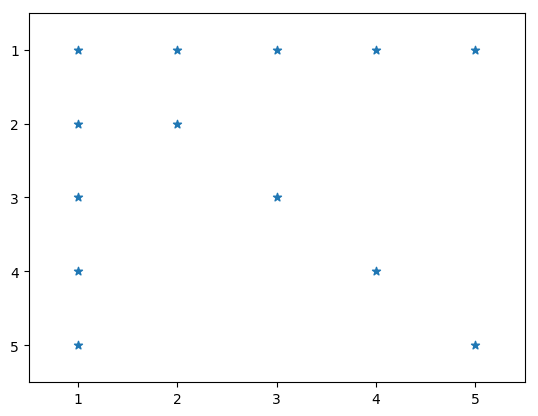

In [4]:
#spy(A,marker="*")
i,j,v=findnz(A);
scatter(i,j,marker="*"); ylim(5.5,0.5); xlim(0.5,5.5);

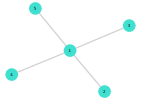

In [5]:
G = Graph(A);
gplot(G, nodelabel=1:5)

# Eliminace

1. krok

In [6]:
n = 5;
A = test_matrix_1(n);

In [7]:
for i=2:n
    f = A[1,1] / A[i,i]
    A[i,:] -= f*A[1,:]
end

In [8]:
Array(A)

5×5 Array{Float64,2}:
  2.0   1.0   1.0   1.0   1.0
 -1.0   1.0  -1.0  -1.0  -1.0
 -1.0  -1.0   1.0  -1.0  -1.0
 -1.0  -1.0  -1.0   1.0  -1.0
 -1.0  -1.0  -1.0  -1.0   1.0

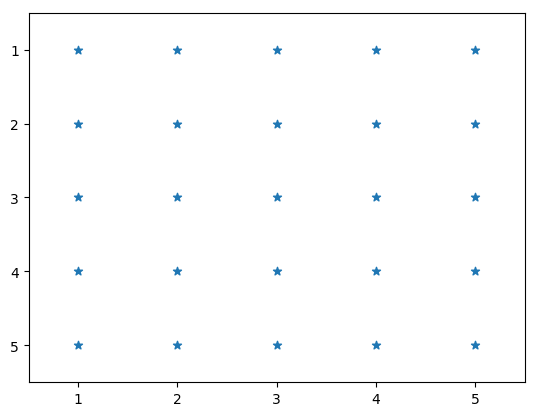

In [9]:
#spy(A, marker="*")
i,j,v=findnz(A);
scatter(i,j,marker="*"); ylim(5.5,0.5); xlim(0.5,5.5);

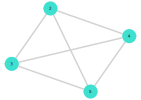

In [10]:
gplot(Graph(A[2:n,2:n]), nodelabel=2:n)

# Vhodna permutace

In [11]:
P = n:-1:1

5:-1:1

In [12]:
A = test_matrix_1(n);

In [13]:
AP = sparse(Array(A[P,P]));
Array(AP)

5×5 Array{Float64,2}:
 2.0  0.0  0.0  0.0  1.0
 0.0  2.0  0.0  0.0  1.0
 0.0  0.0  2.0  0.0  1.0
 0.0  0.0  0.0  2.0  1.0
 1.0  1.0  1.0  1.0  2.0

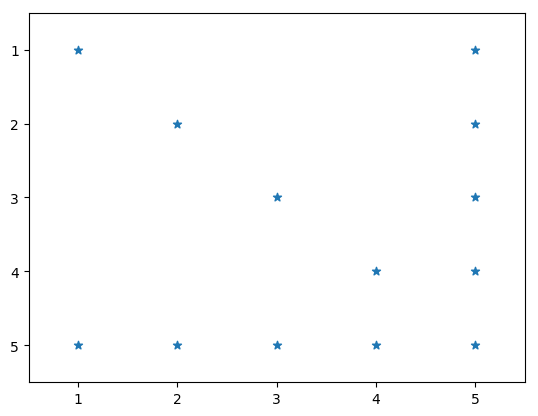

In [14]:
#spy(AP, marker="*")
i,j,v=findnz(AP);
scatter(i,j,marker="*"); ylim(5.5,0.5); xlim(0.5,5.5);

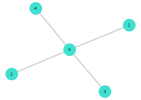

In [15]:
gplot(Graph(AP), nodelabel=1:n)

In [16]:
for i=2:n
    f = AP[1,1] / AP[i,i]
    AP[i,:] -= f*AP[1,:]
end

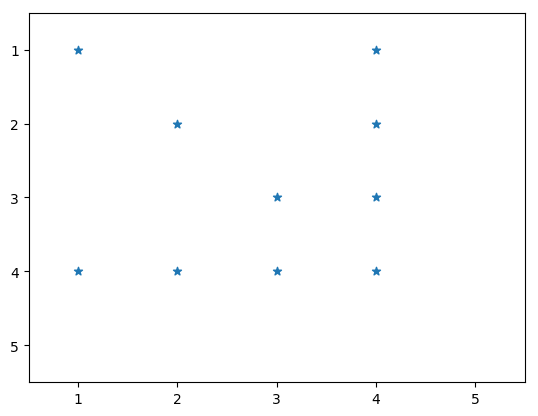

In [17]:
#spy(AP[2:n,2:n], marker="*")
i,j,v=findnz(AP[2:end,2:end]);
scatter(i,j,marker="*"); ylim(5.5,0.5); xlim(0.5,5.5);

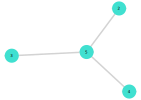

In [18]:
gplot(Graph(Array(AP[2:n,2:n]+AP[2:n,2:n]')), nodelabel=2:n)

# Větší matice

In [19]:
# matice o rozmeru sn^2 x sn^2 odpovidajici diskretizaci laplacianu na ctverci.
function test_matrix_2(sn)
    id(i,j) = i + (j-1)*sn

    A = 6*sparse(I, sn^2, sn^2)

    function add_element!(i,j,i1,j1)
        if 1<=i1 && i1<=sn && 1<=j1 && j1<=sn 
            A[id(i,j), id(i1,j1)] = -1
        end
    end
    
    for i=1:sn
        for j=1:sn
            add_element!(i,j, i+1,j)    
            add_element!(i,j, i-1,j)    
            add_element!(i,j, i,j+1)    
            add_element!(i,j, i,j-1)    
            add_element!(i,j, i+1,j+1)    
            add_element!(i,j, i-1,j-1)
        end
    end
    
    return A
end

test_matrix_2 (generic function with 1 method)

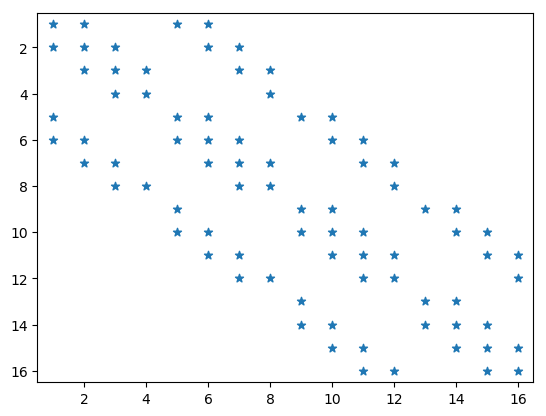

In [20]:
L = test_matrix_2(4);
#spy(L);
i,j,v=findnz(L);
scatter(i,j,marker="*"); ylim(16.5,0.5); xlim(0.5,16.5);

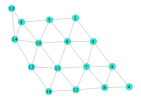

In [21]:
G = []
l = []
push!(G, Graph(L));
push!(l, [v for v=1:nv(G[1])])
gplot(G[1], nodelabel=l[1])

## Eliminace proměnne v grafu

In [22]:
"""
    eliminuj_vrchol(gr, v)

Ze zadaneho grafu `gr` eliminuje vrchol `v` a z vrcholu sosedicich s `v` vytvori kliku.   
"""
function eliminuj_vrchol(gr, v)
    g = Graph(nv(gr)-1)
    
    renum(u) = (u<v ? u : u-1)
    
    for e in edges(gr)
        add_edge!(g, renum(src(e)), renum(dst(e)))
    end

    for s in neighbors(gr,v)
        for d in neighbors(gr,v)
            if s!=v && d!=v
                add_edge!(g, renum(s), renum(d))
            end
        end
    end
    return g
end

eliminuj_vrchol

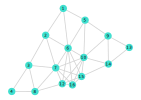

In [23]:
# Eliminace vrcholu 11

push!(G, eliminuj_vrchol(G[1], 11));
push!(l, [v for v in l[1] if v!=11])
gplot(G[2], nodelabel=l[2])

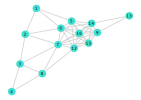

In [24]:
# Eliminace vrcholu 10

push!(G, eliminuj_vrchol(G[2], 10));
push!(l, [v for v in l[2] if v!=l[2][10]])
gplot(G[3], nodelabel=l[3])

In [25]:
# Pocty hran v jednotlivych grafech

ne(G[1]), ne(G[2]), ne(G[3])

(49, 51, 56)

# Minimal degree algoritmus

In [26]:
"""
    minimal_degree_node(gr)

V grafu `gr` nalezne vrchol s nejnizsim stupnem. V pripade vice vrcholu s nejnizsim stupnem vraci prvni z nich.
"""
function minimal_degree_node(g)
    vmin = 1
    δ = degree(g, vmin)
    for v in vertices(g)
        if degree(g,v) < δ
            δ = degree(g,v)
            vmin = v
        end
    end
    return vmin
end

minimal_degree_node

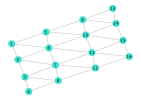

In [27]:
GM = []
lM = []
push!(GM, Graph(L));
push!(lM, [v for v=1:nv(G[1])])
gplot(GM[1], nodelabel=lM[1])

In [28]:
minimal_degree_node(GM[1])

4

v=4, degree = 3


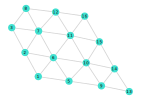

In [29]:
# Eliminace vrcholu s nejnizsim stupnem

v = minimal_degree_node(GM[1])
println("v=",lM[1][v], ", degree = ", degree(GM[1],v))
push!(GM, eliminuj_vrchol(GM[1], v));
push!(lM, [i for i in lM[1] if i!=lM[1][v]])
gplot(GM[2], nodelabel=lM[2])

v=13, degree = 3


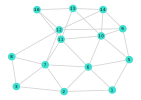

In [30]:
v = minimal_degree_node(GM[2])
println("v=",lM[2][v], ", degree = ", degree(GM[2],v))
push!(GM, eliminuj_vrchol(GM[2], v));
push!(lM, [i for i in lM[2] if i!=lM[2][v]])
gplot(GM[3], nodelabel=lM[3])

v=1, degree = 4


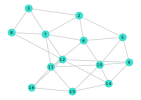

In [31]:
v = minimal_degree_node(GM[3])
println("v=",lM[3][v], ", degree = ", degree(GM[3],v))
push!(GM, eliminuj_vrchol(GM[3], v));
push!(lM, [i for i in lM[3] if i!=lM[3][v]])
gplot(GM[4], nodelabel=lM[4])

In [32]:
ne(GM[1]), ne(GM[2]), ne(GM[3]), ne(GM[4])

(49, 46, 45, 42)